# <center>Natural Language Processing with Disaster Tweetsn<center>

![](https://ak.picdn.net/shutterstock/videos/29359330/thumb/4.jpg)



####  <center>Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). But, it’s not always clear whether a person’s words are actually announcing a disaster.</center>  



-----------------

Hello!

This notebook will consist of several blocks:
1. **| EDA & Feature Engineering |**
2. **| Data Preprocessing |**
3. **| machine learning |**

If necessary, you can quickly move to the solution blocks of this competition that interest you using the table of contents.

In this notebook, **I will not use deep learning methods, Glove, BERT, etc.** I will probably create a separate notebook using these technologies, but for now **I will focus on the most basic NLP methods.**

Okay, time to get started!

First, let's import the start modules **(I will not import all the modules that will be used in the notebook at once. Instead, I will import them separately, depending on the tasks of the block.)**

In [1]:
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix, hstack

import string
import nltk
from nltk.corpus import stopwords

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

pd.options.mode.chained_assignment = None # Disabling the pandas warning

In [2]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
output_example = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


When naming the target attribute **"target"**, I sometimes get confused and forget what the classes of this attribute mean, so I decided to rename it to the understandable name **"real_tweet"**

In [4]:
train.rename(columns={'target':'real_tweet'}, inplace=True)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7613 non-null   int64 
 1   keyword     7552 non-null   object
 2   location    5080 non-null   object
 3   text        7613 non-null   object
 4   real_tweet  7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


-------------

#  <center>| EDA & Feature Engineering |</center>

![](https://i.ytimg.com/vi/Xk0TTY0kZ4A/hqdefault.jpg?sqp=-oaymwEjCPYBEIoBSFryq4qpAxUIARUAAAAAGAElAADIQj0AgKJDeAE=&rs=AOn4CLB4PPIiRY9YGVA93j_JQBIUQCmF-g)  

Let's start block **| EDA & Feature Engineering |**

Unfortunately, most notebooks only examine and transform the **"text"** variable

In this notebook, I will try to **use more features**, and also try to **generate new features**

##  Real_tweet & Text Analysis 

Let's start with the analysis of the target feature, first take a look at the **ratio of classes**

In [6]:
train['real_tweet'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: real_tweet, dtype: float64

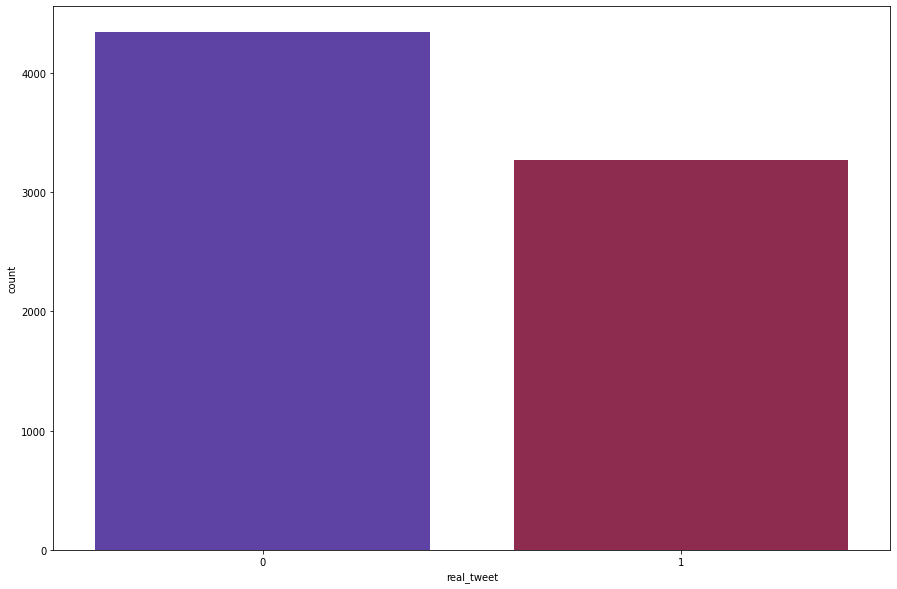

In [7]:
plt.figure(figsize=(15,10))
sns.countplot(data=train, x='real_tweet', palette='twilight', saturation=1);

Excellent, feature classes do **not have a strong imbalance**, an approximate ratio of **6:4**

Now let's take a **look at some examples of tweets from the "text" feature.**

**Divide them into real and fake** and display them on the screen

In [8]:
real_tweets = train[train['real_tweet']==1]['text']
fake_tweets = train[train['real_tweet']==0]['text']

In [9]:
random_real_tweets = real_tweets.sample(5).values
random_fake_tweets = fake_tweets.sample(5).values


print('Real tweets:\n')
for i, tweet in enumerate(random_real_tweets):
    print('[{0}] {1}\n'.format(i+1, tweet))
    if i == 5:
        break

print('-'*90)
print('Fake tweets:\n')
for i, tweet in enumerate(random_fake_tweets):
    print('[{0}] {1}\n'.format(i+1, tweet))
    if i == 5:
        break

Real tweets:

[1] The Latest: More homes razed by Northern California wildfire: The latest on wildfires burning in California andÛ_ http://t.co/0Keh2TReNy

[2] I feel like a tornado http://t.co/iZJK6kpWiZ

[3] A GPM satellite 'bullseye' in Typhoon Soudelor http://t.co/piVeUPiRKY

[4] The first piece of wreckage from the first-ever lost Boeing 777 which vanished back in early March along with the 239 people on board has

[5] Plane debris discovered on Reunion Island belongs to flight MH370 ÛÒ Malaysian PM http://t.co/jkc0DIqvXC

------------------------------------------------------------------------------------------
Fake tweets:

[1] 'We are now prepared to obliterate more rapidly and completely every productive enterprise the Japanese have above ground in any city.'

[2] @chikislizeth08 you're not injured anymore? ??

[3] No better feeling than seeing and being on stage with my day ones...... 22 year friendships and we still body bagging mics together.

[4] Reddit Will Now Quaranti

When executing the code above, I get always different **5 real tweet examples and 5 fake tweet examples using the sample() function

So I decided to try to manually understand the difference between a real tweet and a fake tweet.

1) **It seemed to me that real tweets have a longer text length than fake tweets**

2) **Real tweets seem to have more numbers in the text**

3) **It can be assumed that real tweets will be written more competently and contain more punctuation in the text**

4) **Tweets often use http links, but it seemed to me that real tweets contained more of them**

5) **It also seemed to me that there are more hastags in real tweets**

Based on the findings obtained in the process of manual analysis, we will generate new features and see how they affect the target feature

Let's start by creating **"len_text"**

In [10]:
train['len_text'] = train['text'].apply(len)
test['len_text'] = test['text'].apply(len)

In [11]:
train.groupby(['real_tweet'])['len_text'].describe().T

real_tweet,0,1
count,4342.000000,3271.000000
mean,95.706817,108.113421
std,35.885924,29.309854
min,7.000000,14.000000
25%,68.000000,88.000000
50%,101.000000,115.000000
75%,130.000000,136.000000
max,157.000000,151.000000


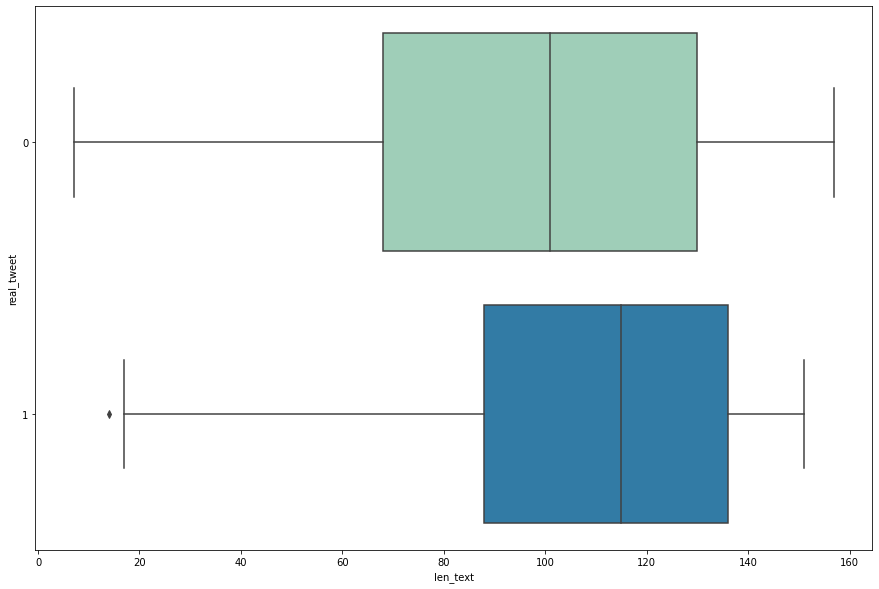

In [12]:
plt.figure(figsize=(15,10))
sns.boxplot(data=train, x='len_text', y='real_tweet', orient='h', palette='YlGnBu');

Indeed, real tweets on average have more characters.

Now let's take a look at **points '2)' and '3)'**

Let's create 2 features for each hypothesis: **check and count**

I don't know which ones will give the best result as there are suggestions:

**count_punctation** will be highly correlated with len_text

**count_digits** will count the number 13 as 1 and 3, which may result in an incorrect estimate of the actual number of numbers in the tweet

**check_digits** and check_punctation may not show a possible relationship with the target feature

Therefore, we will create all 4 features and analyze them

In [13]:
def check_digits(text):
    if [char for char in text if char in string.digits]:
        return 1
    else:
        return 0
    
def check_punctation(text):
    if [char for char in text if char in string.punctuation]:
        return 1
    else:
        return 0
    
def count_punctation(text):
    count = 0
    for char in text:
        if char in string.punctuation:    
            count +=1
    return count

def count_digits(text):
    count = 0
    for char in text:
        if char in string.digits:    
            count +=1
    return count

In [14]:
train['check_digits'] = train['text'].apply(lambda x: check_digits(x))
train['check_punctation'] = train['text'].apply(lambda x: check_punctation(x))
train['count_punctation'] = train['text'].apply(lambda x: count_punctation(x))
train['count_digits'] = train['text'].apply(lambda x: count_digits(x))


test['check_digits'] = test['text'].apply(lambda x: check_digits(x))
test['check_punctation'] = test['text'].apply(lambda x: check_punctation(x))
test['count_punctation'] = test['text'].apply(lambda x: count_punctation(x))
test['count_digits'] = test['text'].apply(lambda x: count_digits(x))

In [15]:
train.groupby(['real_tweet'])['count_punctation'].describe().T

real_tweet,0,1
count,4342.000000,3271.000000
mean,6.309074,7.543565
std,4.830297,4.195437
min,0.000000,0.000000
25%,3.000000,5.000000
50%,6.000000,7.000000
75%,9.000000,10.000000
max,61.000000,27.000000


In [16]:
train.groupby(['real_tweet'])['count_digits'].mean()

real_tweet
0    1.590511
1    2.637420
Name: count_digits, dtype: float64

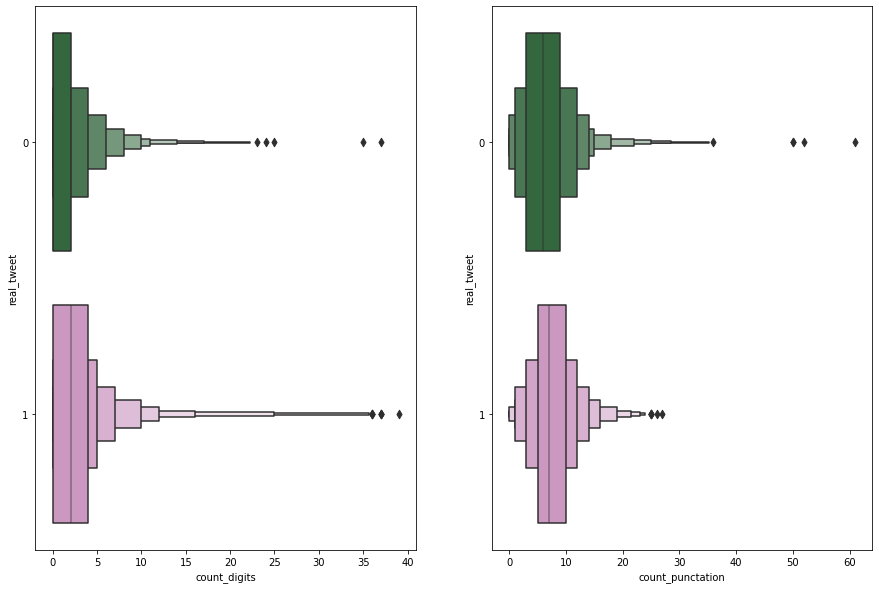

In [17]:
fig, ax =plt.subplots(1,2, figsize=(15,10))
sns.boxenplot(data=train, x='count_digits', y='real_tweet', orient='h', ax=ax[0], palette='cubehelix')
sns.boxenplot(data=train, x='count_punctation', y='real_tweet', orient='h', ax=ax[1], palette='cubehelix');

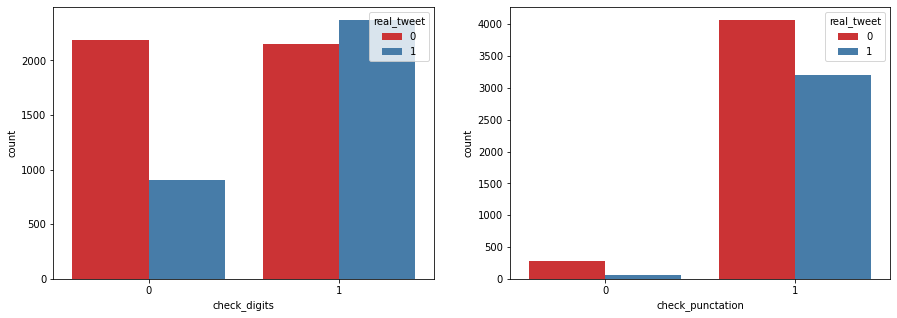

In [18]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.countplot(data=train, x='check_digits', hue='real_tweet', ax=ax[0], palette='Set1')
sns.countplot(data=train, x='check_punctation', hue='real_tweet', ax=ax[1], palette='Set1');

Great, **check_digits** seems like a really important feature.

**check_punctation** did not show any relationship with the target feature, the distribution of the target variable has approximately the same ratio

The boxplot **count_punctation** also does not show a strong relationship with the target feature, perhaps the feature does not make any sense

Later we will decide what to do with them, but for now let's deal with **points 4) and 5)**

In [19]:
train['check_http'] = train['text'].str.contains('http')
train['check_hash'] = train['text'].str.contains('#')

test['check_http'] = test['text'].str.contains('http')
test['check_hash'] = test['text'].str.contains('#')

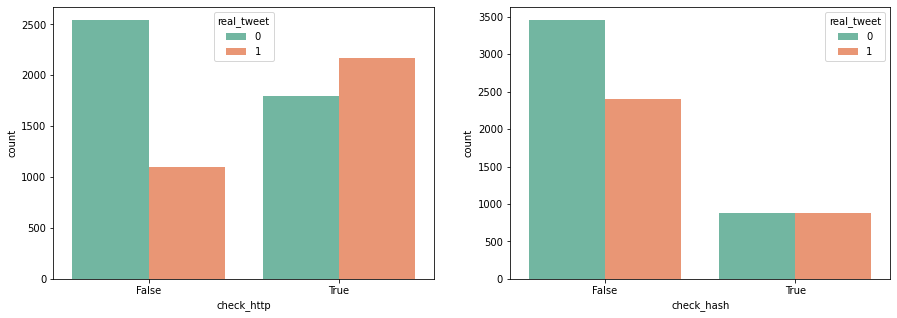

In [20]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.countplot(data=train, x='check_http', hue='real_tweet', ax=ax[0], palette='Set2' )
sns.countplot(data=train, x='check_hash', hue='real_tweet', ax=ax[1], palette='Set2');

As we expected, **check_http** has an effect on the target attribute

At first glance, it seemed to me that real tweets contain more hashtags, but **check_hash showed that this is not true**, but the distribution of the target feature in the presence of a hashtag has a 1:1 ratio. We remember that the target feature had a ratio of 6:4, so we will assume that **this feature is important**

-------------

Great, we've generated some new features that can help the model better distinguish between a real tweet and a fake tweet.

Now let's **go back to the feature text and clean it up** (Initially I wanted to clean up the text in block 2, but I decided that I would do it now so that block 2 can be devoted to deeper predprocessing)

In [21]:
train.head()

,id,keyword,location,text,real_tweet,len_text,check_digits,check_punctation,count_punctation,count_digits,check_http,check_hash
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,0,1,1,0,False,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,0,1,1,0,False,False
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,0,1,3,0,False,False
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,1,1,2,5,False,True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,0,1,2,0,False,True


Let's create a function that will perform the process of cleaning the text and analyze it in more detail.

1. To begin with, we will **remove all stop-words** (i, where, our, the, etc.) from the text, this is necessary, since regardless of the class of the target feature, these words will appear very often in tweets and will not affect in any way choice of target variable class. This makes no sense, because when studying the words of a tweet, we want to find the relationship between the words used and the distribution of target feature classes, and stop-words will only create noise in the data

2. **Convert all text to lowercase**

3. **Delete all http requests** (the http request link will not be deleted, but then we will remove the remaining characters using **string.punctation**)

4. **Replace all punctuation from the text with char+' '**, as a similar situation can happen: "fish,cat". Due to the fact that there is no space after the comma, we would get fishkat

5. **Remove all other characters that are not alpha, numbers and space**

6. **Remove extra spaces between words**


I **didn’t use regular expressions** in the function, because I don’t understand them very well, but I don’t want to simply copy other people’s solutions without understanding

In [22]:
def clean_text(text):
    
    stop_words = stopwords.words('english')
    stop_words.append('i\'m') # I saw this abbreviation, but it is not in the list of stop-words, so I added it manually
    
    text = text.lower()
    text = ' '.join([char for char in text.split() if char not in stop_words])
    
    text = ' '.join(['' if 'http' in char else char for char in text.split()])
    
    text = ''.join([char+' ' if char in string.punctuation else char for char in text ])
    
    text = ''.join([char for char in text if char in string.ascii_lowercase or char in ' ' or  char in string.digits])
    
    text = ' '.join(text.split())
    
    return text

In [23]:
check_text_real = train[train['real_tweet']==1]['text'].head(5)
check_text_fake = train[train['real_tweet']==0]['text'].head(5)

With these cycles, we will demonstrate the text **before using clean_text and after using clean_text**

In [24]:
for i, text in enumerate(check_text_real):
    print(f'Clean [{i+1}]:', clean_text(text), end='\n\n')
    print(f'Real [{i+1}]:', text, end='\n\n')
    print()

Clean [1]: deeds reason earthquake may allah forgive us

Real [1]: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


Clean [2]: forest fire near la ronge sask canada

Real [2]: Forest fire near La Ronge Sask. Canada


Clean [3]: residents asked shelter place notified officers evacuation shelter place orders expected

Real [3]: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected


Clean [4]: 13 000 people receive wildfires evacuation orders california

Real [4]: 13,000 people receive #wildfires evacuation orders in California 


Clean [5]: got sent photo ruby alaska smoke wildfires pours school

Real [5]: Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 




In [25]:
for i, text in enumerate(check_text_fake):
    print(f'Clean [{i+1}]:', clean_text(text), end='\n\n')
    print(f'Real [{i+1}]:', text, end='\n\n')
    print()

Clean [1]: what s man

Real [1]: What's up man?


Clean [2]: love fruits

Real [2]: I love fruits


Clean [3]: summer lovely

Real [3]: Summer is lovely


Clean [4]: car fast

Real [4]: My car is so fast


Clean [5]: goooooooaaaaaal

Real [5]: What a goooooooaaaaaal!!!!!!




In [26]:
train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

In [27]:
train.head().T

,0,1,2,3,4
id,1,4,5,6,7
keyword,NaN,NaN,NaN,NaN,NaN
location,NaN,NaN,NaN,NaN,NaN
text,Our Deeds are the Reason of this #earthquake M...,Forest fire near La Ronge Sask. Canada,All residents asked to 'shelter in place' are ...,"13,000 people receive #wildfires evacuation or...",Just got sent this photo from Ruby #Alaska as ...
real_tweet,1,1,1,1,1
len_text,69,38,133,65,88
check_digits,0,0,0,1,0
check_punctation,1,1,1,1,1
count_punctation,1,1,3,2,2
count_digits,0,0,0,5,0


Great, we have processed the text, generated new features.

Now let's analyze the starting additional features, starting with the **keyword**

## Keyword Analysis

In [28]:
train['keyword'].isnull().sum()

61

There are **not very many missing keyword values in the data**, so I think they could be removed, but the absence of a keyword can affect the target feature, for example, when fake tweets, people do not use the keyword.

Let's test this and fill in the missing values with **Empty**

In [29]:
train['keyword'] = train['keyword'].fillna('Empty')
test['keyword'] = test['keyword'].fillna('Empty')

In [30]:
train['keyword'].unique()

array(['Empty', 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 

In [31]:
train['keyword'].nunique()

222

keyword contains many unique values that are similar in meaning to each other.

They can be combined into one value like **destroy and destroyed**

However, the **use of more colloquial keywords may have an impact on the target feature**, so I will not process them, as we may lose the emotional color of the keyword value.

P.S. I am new to NLP, so I draw some conclusions based on my own assumptions. For example, in this case, I could misunderstand the semantic meaning of keyword

P.S. Still, my guesses were confirmed, the models had better results, without processing the keyword values :)

In [32]:
train[train['real_tweet'] == 1]['keyword'].value_counts()

Empty          42
wreckage       39
outbreak       39
derailment     39
typhoon        37
               ..
electrocute     1
epicentre       1
body%20bags     1
body%20bag      1
blazing         1
Name: keyword, Length: 221, dtype: int64

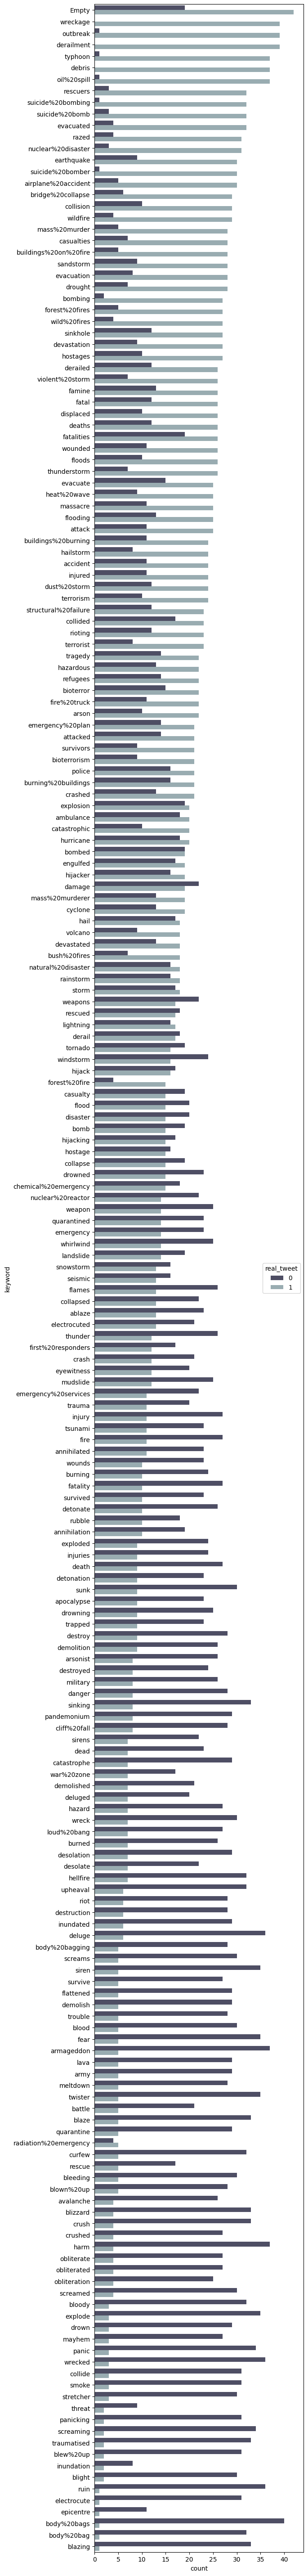

In [33]:
plt.figure(figsize=(6,75), dpi=100)
sns.countplot(data=train, y='keyword', hue='real_tweet',
              order=train[train['real_tweet'] == 1]['keyword'].value_counts().index,
             palette='bone');

The countplot clearly shows how most keyword values have a **serious impact on the target feature.**

Ok, we are done with keyword, now let's start analysis **location**

## Location Analysis

In [34]:
train['location'].isnull().sum()

2533

In [35]:
print("missing values :", round(train['location'].isnull().sum()/train.shape[0],3),'%')

missing values : 0.333 %


**Missing location values 3:10 of the total data size!**

This is a large number, so **I'm not sure if this feature can be included in the training data.**

However, let's take a closer look at the values of location

In [36]:
train['location'].nunique()

3341

In [37]:
top_location = train['location'].value_counts(normalize=True).head(50).index

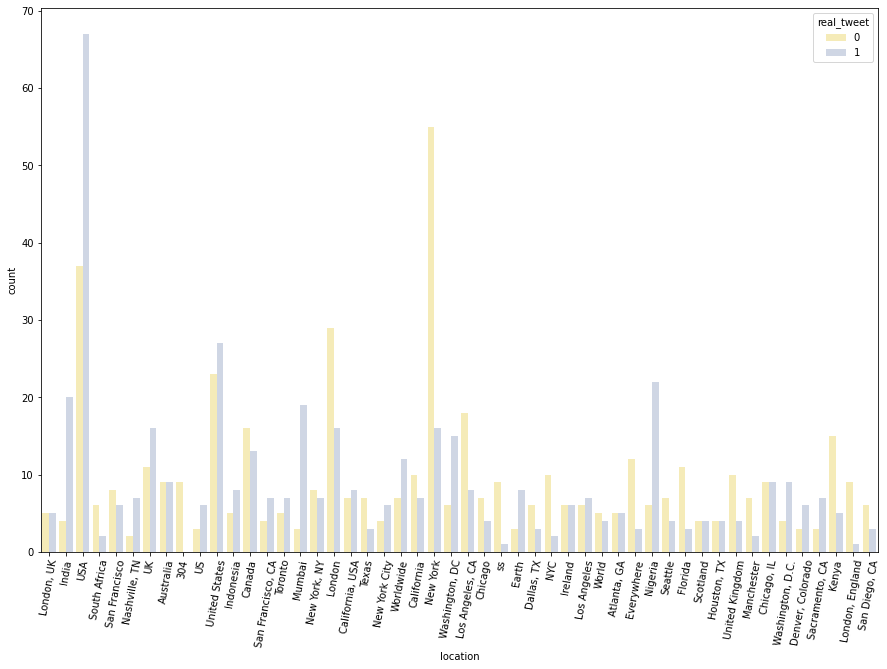

In [38]:
plt.figure(figsize=(15,10))
sns.countplot(data=train[train['location'].isin(top_location)], x='location', hue='real_tweet', palette='Pastel2_r')
plt.xticks(rotation=80);

People indicated in the location of the **city, country or city-country**

The countplot shows that most of the tweets were from the **USA and UK.**

This large number of unique values tells us that there are very few tweets per location value, not counting USA and UK.

Perhaps it is worth clearing this feature and **entering only 3 unique values: UK, USA, Other**

However, I won't do this, because I still think that the number of missing values in location is very large and by setting the value to empty we will **create a lot of artificial information.**

**In the future, I will not use this feature.**

P.S. If this is a really important sign and I'm wrong, write me about it. Alas, I have not seen other laptops with good results who used location


----------------------

#  <center>| Data Preprocessing |</center>

![](https://iprofi.kg/wp-content/uploads/2021/07/60ffd0153c1d3549690580.gif)

Ok, let's move on to the next block of solving the competition, **data preprocessing.**

But let's take a **look at the correlation matrix**. In the past, we have created some features that can be highly correlated with each other.

1. **Previously, we thought that count_punctation is a better choice than check_punctation**, however, this feature is moderately correlated with other features, but carries the same information to the target feature, so we **remove count_punctation**

2. **Leave check_digits** as it carries more information to the target feature

3. **Remove the location**, we decided that due to the large number of missing values, it will not help in training the model

4. **Remove id and text**, we won't need them anymore

In [39]:
clean_train = train.drop(['count_digits','count_punctation','id','location', 'text'], axis=1)
clean_test  = test.drop(['count_digits','count_punctation','id','location', 'text'], axis=1)

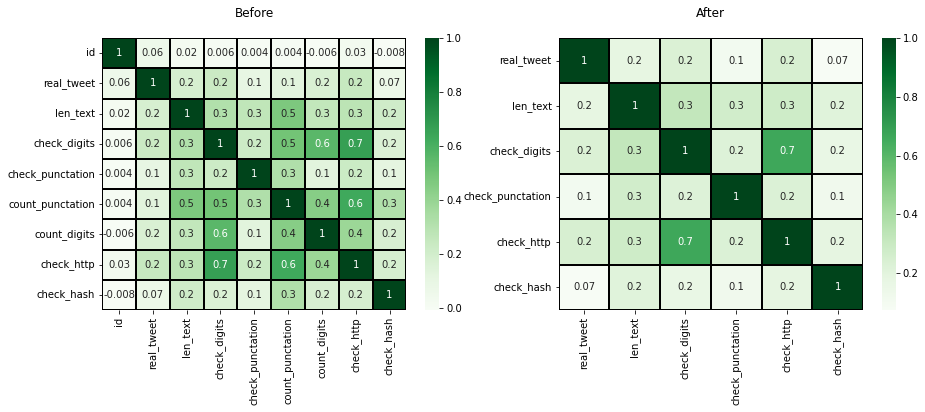

In [40]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
ax[0].title.set_text('Before\n')
sns.heatmap(train.corr(), annot=True, ax=ax[0], fmt='.1g', cmap='Greens', linewidths=2, linecolor='black')
ax[1].title.set_text('After\n')
sns.heatmap(clean_train.corr(), annot=True, ax=ax[1], fmt='.1g', cmap='Greens', linewidths=2, linecolor='black');

## Additional Features Preprocessing

Great, now we need to process our features for further use.

In [41]:
clean_train.head()

,keyword,real_tweet,len_text,check_digits,check_punctation,check_http,check_hash,clean_text
0,Empty,1,69,0,1,False,True,deeds reason earthquake may allah forgive us
1,Empty,1,38,0,1,False,False,forest fire near la ronge sask canada
2,Empty,1,133,0,1,False,False,residents asked shelter place notified officer...
3,Empty,1,65,1,1,False,True,13 000 people receive wildfires evacuation ord...
4,Empty,1,88,0,1,False,True,got sent photo ruby alaska smoke wildfires pou...


Convert **bool features to int**

P.S. In the process of generating features, I did not think that they would have to be transformed :)

In [42]:
clean_train['check_http'] = clean_train['check_http'].apply(lambda x: 1 if x else 0)
clean_train['check_hash'] = clean_train['check_hash'].apply(lambda x: 1 if x else 0)

clean_test['check_http'] = clean_test['check_http'].apply(lambda x: 1 if x else 0)
clean_test['check_hash'] = clean_test['check_hash'].apply(lambda x: 1 if x else 0)

Now import and apply **MinMaxScaler()** to standardize len_text

We use **MinMax standardization to get the values [0:1]**. In what follows, we will use **Naive Bayes**, which requires only **positive values.**

In [43]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
scal = MinMaxScaler()
scal.fit(clean_train['len_text'].values.reshape(-1,1))
clean_train['len_text'] = scal.transform(clean_train['len_text'].values.reshape(-1,1))
clean_test['len_text'] = scal.transform(clean_test['len_text'].values.reshape(-1,1))

## Text Preprocessing

For this block, I need to explain what I'm doing

1. We apply **word_tokenize()** to the text in order to split() all the words of the text. Why didn't we use split()? word_tokenize was created to handle large text sizes, so **word_tokenize is faster than split()**


2. We apply **WordNetLemmatizer()** to the text in order to bring the words to the basic forms of the word, preserving the contextual meaning of the sentence.

P.S. I have a bad level of English, so it's hard for me to explain in simple words what lemmatization is :(

In [45]:
from nltk.stem import WordNetLemmatizer

In [46]:
clean_train['clean_text'] = clean_train['clean_text'].apply(lambda x: nltk.tokenize.word_tokenize(x))
clean_test['clean_text'] = clean_test['clean_text'].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [47]:
print('Before: ', train['clean_text'][1])
print('After: ', clean_train['clean_text'][1])

Before:  forest fire near la ronge sask canada
After:  ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']


In [48]:
def lem_word(text):
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text]
    return text

In [49]:
clean_train['clean_text'] = clean_train['clean_text'].apply(lem_word)
clean_test['clean_text'] = clean_test['clean_text'].apply(lem_word)

In [50]:
print('Before: ', train['clean_text'][16])
print('After: ', clean_train['clean_text'][16])

Before:  love fruits
After:  ['love', 'fruit']


## Constructing Training Dataset

For this block, I need to explain what I'm doing

1. I use **sample() to shuffle the data** as it is not in random order (Look at the keyword feature. Empty values only occur in the leading and last indexes)


2. I **divide the data into X_train, y_train, X_test**


3. After tokenization, we **need to turn clean_text into str()** (Now it is a list)


4. I **use TfidfVectorizer()**. This function turns the text into a **sparse matrix**, in which each word found in the dictionary is assigned its own cell. Next, for each word, **we calculate the frequency of occurrences** in clean_text and keyword. **This is necessary to give lower weights to frequently used words.**


5. **Use hstack() to merge 2 sparse matrices**


6. **Transform the remaining features into a sparse matrix and combine with the main sparse matrix X_[]_tfid**


At each step, we display the shape so as not to accidentally lose data in the process of creating training and test data

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
clean_train = clean_train.sample(frac=1).reset_index(drop=True)

In [53]:
X_train = clean_train.drop(['real_tweet'], axis=1)
y_train = clean_train['real_tweet']
X_test = clean_test.copy()

In [54]:
print('Train shape: ', X_train.shape[0])
print('\nTest shape: ', X_test.shape[0])
print('-'*30)
print('Train y: \n\n', y_train.value_counts(), sep='')

Train shape:  7613

Test shape:  3263
------------------------------
Train y: 

0    4342
1    3271
Name: real_tweet, dtype: int64


In [55]:
X_train['clean_text'] = X_train['clean_text'].apply(lambda x: ' '.join(x))
X_test['clean_text'] = X_test['clean_text'].apply(lambda x: ' '.join(x))

In [56]:
tfid = TfidfVectorizer()
#count_vect = CountVectorizer()

X_train_tfid_text = tfid.fit_transform(X_train['clean_text'])
X_test_tfid_text = tfid.transform(X_test['clean_text'])

X_train_tfid_keyword = tfid.fit_transform(X_train['keyword'])
X_test_tfid_keyword = tfid.transform(X_test['keyword'])

#X_train_tfid_keyword = count_vect.fit_transform(X_train['keyword'])
#X_val_tfid_keyword = count_vect.transform(X_val['keyword'])
#X_test_tfid_keyword = count_vect.transform(X_test['keyword'])

In [57]:
X_train_tfid = hstack([X_train_tfid_text, X_train_tfid_keyword])
X_test_tfid = hstack([X_test_tfid_text, X_test_tfid_keyword])

In [58]:
print('Text shape')
print('Train: ' ,X_train_tfid_text.shape)
print('Test: ' ,X_test_tfid_text.shape)
print('-'*25)
print('Keyword shape')
print('Train: ' ,X_train_tfid_keyword.shape)
print('Test: ' ,X_test_tfid_keyword.shape)
print('-'*25)
print('Total shape')
print('Train: ' ,X_train_tfid.shape)
print('Test: ' ,X_test_tfid.shape)

Text shape
Train:  (7613, 15702)
Test:  (3263, 15702)
-------------------------
Keyword shape
Train:  (7613, 240)
Test:  (3263, 240)
-------------------------
Total shape
Train:  (7613, 15942)
Test:  (3263, 15942)


In [59]:
def another_feature_to_csr_matrix(feature, matrix):
    new_matrix = csr_matrix(hstack([matrix, feature.values.reshape(-1,1)]))
    return new_matrix

In [60]:
for feature in X_train.loc[:,'len_text':'check_hash']:
    X_train_tfid = another_feature_to_csr_matrix(X_train[feature], X_train_tfid)

for feature in X_test.loc[:,'len_text':'check_hash']:
    X_test_tfid = another_feature_to_csr_matrix(X_test[feature], X_test_tfid)

In [61]:
print('Total shape')
print('Train: ' ,X_train_tfid.shape)
print('Test: ' ,X_test_tfid.shape)

Total shape
Train:  (7613, 15947)
Test:  (3263, 15947)


Ok, now **let's start creating and training the model**

------------------

#  <center>| Machine Learning |</center>


![](https://4.bp.blogspot.com/-R1w3hy8_V6k/WuSOGXuhn1I/AAAAAAAATio/z4_6Pdwutk4qggn2W4dwAjFQC1Fj4gFrACLcBGAs/s640/1_FYFI4jbAUMqbXxlo6V_lBA.png) 

Great, in this block we will do machine learning and create a model that will learn to predict the truth of a tweet

First, import the necessary libraries

In this notebook, I will use models such as:

1) **Multinomial Naive Bayes** (As recommended for working with texts)

2) **Logistic Regression**

3) **SVM**

4) I will try to train **Logistic Regression and SVM using SGD**

5) At the end we **use StackingClassifier to predict the final result based on the available models**


In [62]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

I will write functions to quickly call the necessary metrics

We did **not split the data into X_validation and X_train**, instead, we will use **cross-validation** on X_train and evaluate the **f1 score** of the model on **cross_val_score**

In [63]:
random_state = 1

def print_metrics(estimator):
    acc = cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    prec = cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='precision', n_jobs=-1)
    rec = cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='recall', n_jobs=-1)
    f1 = cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='f1', n_jobs=-1)
    
    print(estimator,'\n--------------------------------')
    print('ACCURACY:', np.mean(acc))
    print('PRECISION:', np.mean(prec))
    print('RECALL:', np.mean(rec))
    print('\nMain metric:', '\n--------------------------------', sep='')
    print('F1:', np.mean(f1))
    print('--------------------------------\n')

def save_main_metric(estimator):
    f1 = np.mean(cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='f1', n_jobs=-1))
    final_scores.append(f1)

## Base models

I define the selected models by **specifying hyperparameters**

I did not introduce an additional block with GridSearch, so as not to overload the notebook with unnecessary information

Instead, manually **set the optimal non-overtrained parameters**

In [64]:
nb = MultinomialNB(fit_prior=False)

logit = LogisticRegression(C=10 ,max_iter=1000)

svc = SVC(kernel='linear')

sgd_svm = SGDClassifier(alpha=5e-4, random_state=random_state)

sgd_log = SGDClassifier(loss='log', alpha=5e-05, random_state=random_state)

In [65]:
print_metrics(nb)
print_metrics(logit)
print_metrics(svc)
print_metrics(sgd_svm)
print_metrics(sgd_log)

MultinomialNB(fit_prior=False) 
--------------------------------
ACCURACY: 0.7772233357654234
PRECISION: 0.733484795953664
RECALL: 0.7563386282539656

Main metric:
--------------------------------
F1: 0.7446776624685992
--------------------------------

LogisticRegression(C=10, max_iter=1000) 
--------------------------------
ACCURACY: 0.797188528610295
PRECISION: 0.7906168489400177
RECALL: 0.7184313131907714

Main metric:
--------------------------------
F1: 0.752708154292178
--------------------------------

SVC(kernel='linear') 
--------------------------------
ACCURACY: 0.7994212060247502
PRECISION: 0.8012232900737025
RECALL: 0.7092603648982361

Main metric:
--------------------------------
F1: 0.7523928078179162
--------------------------------

SGDClassifier(alpha=0.0005, random_state=1) 
--------------------------------
ACCURACY: 0.7898328794777664
PRECISION: 0.799339876667231
RECALL: 0.6835753748349717

Main metric:
--------------------------------
F1: 0.7362887834537842
------

Great, it seems that all models show approximately the **same F1 score.**

First you need to show the target metric formula: **F1 = 2 * (precision * recall) / (precision + recall)**

F1, along with Roc auc, can be considered a metric of the overall quality of the model, since it uses precision and recall in its formula


As we can see, some **Precision and Recall models differ**

For example, **MultinomialNB has approximately the same Precision and Recall - ~ 0.75**

And **SVM has Precision 0.8 and Recall 0.7**

However, **F1 for MultinomialNB and SVM is approximately the same**

## Ensemble Model : Stacking

Training multiple models to solve the same problem are combined and get the best result.

This approach in machine learning is called the **ensemble method.**

The basic premise is that the result of multiple models will be more accurate than the result of only one model.

So let's use the StackingClassifier to get the average result by aggregating all the models.

In this notebook, I am **using a StackingClassifier with a logit meta model.**

P.S. I don't understand very well how to choose a meta model, but for this task, logit showed better results than other models.

In [66]:
stacking_estimators = [('svc', svc), ('nb', nb), ('sgd_svm', sgd_svm), ('sgd_log', sgd_log)]

In [67]:
stacking = StackingClassifier(stacking_estimators, logit, cv=5, n_jobs=-1)

In [68]:
print_metrics(stacking)

StackingClassifier(cv=5,
                   estimators=[('svc', SVC(kernel='linear')),
                               ('nb', MultinomialNB(fit_prior=False)),
                               ('sgd_svm',
                                SGDClassifier(alpha=0.0005, random_state=1)),
                               ('sgd_log',
                                SGDClassifier(alpha=5e-05, loss='log',
                                              random_state=1))],
                   final_estimator=LogisticRegression(C=10, max_iter=1000),
                   n_jobs=-1) 
--------------------------------
ACCURACY: 0.8000785123021416
PRECISION: 0.7954441950689266
RECALL: 0.7199592439671821

Main metric:
--------------------------------
F1: 0.7557194213024987
--------------------------------



## Results Analysis

Great, let's take a **look at the results of all models**, for this I will collect their results using **save_main_metric()**

P.S. I described this function earlier, along with print_metric()

In [69]:
final_scores = [] #check save_main_metric()
all_model = [nb, logit, svc, sgd_svm, sgd_log, stacking]
name_model = ['Multinomial NB','Logistic Regression','SVM','SGD SVM', 'SGD Logit', 'Stacking model']

for model in all_model:
    save_main_metric(model)
    

In [70]:
result_df = pd.DataFrame(final_scores, index=name_model, columns=['F1 Score'])

In [71]:
result_df.T

,Multinomial NB,Logistic Regression,SVM,SGD SVM,SGD Logit,Stacking model
F1 Score,0.744678,0.752708,0.752393,0.736289,0.745519,0.755719


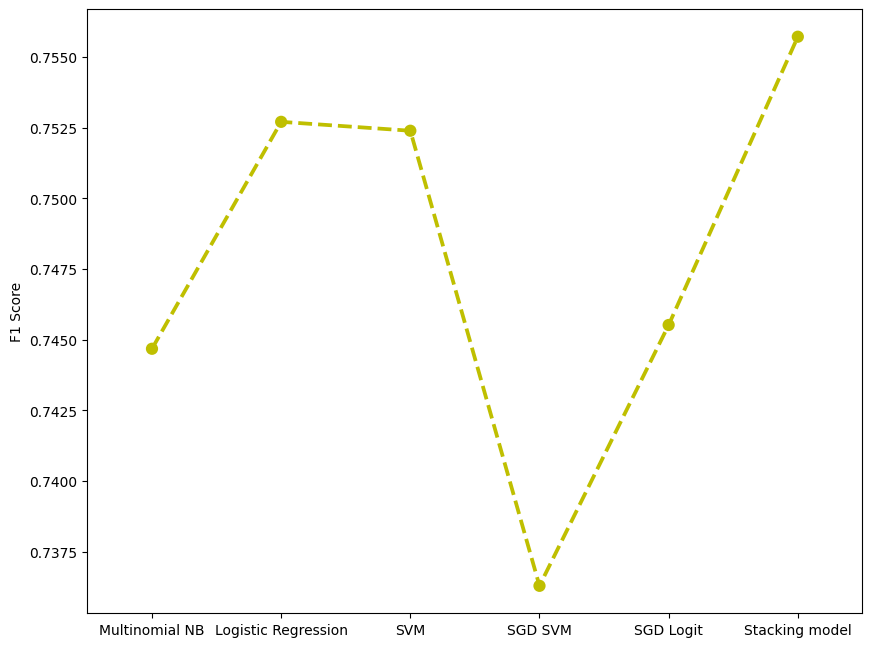

In [72]:
plt.figure(figsize=(10,8), dpi=100)
sns.pointplot(y=result_df['F1 Score'] , x=result_df.index ,markers='o',linestyles='--', color='y');

As we can see, the **Stacking model got the best result F1**

Great, in that case, use it for the final results.

#  <center>| Final result & Submission |</center>

In [73]:
stacking.fit(X_train_tfid, y_train);
pred_train_stack = stacking.predict(X_train_tfid)

In [74]:
def conf_matrix_plot(y_true, y_pred):
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='.4g', cmap='RdGy', linewidths=3, linecolor='black')
    plt.title('\nConfusion Matrix for Train\n', fontsize=25);
    plt.xlabel('Predicted Values', fontsize=15)
    plt.ylabel('Actual Values', fontsize=15);

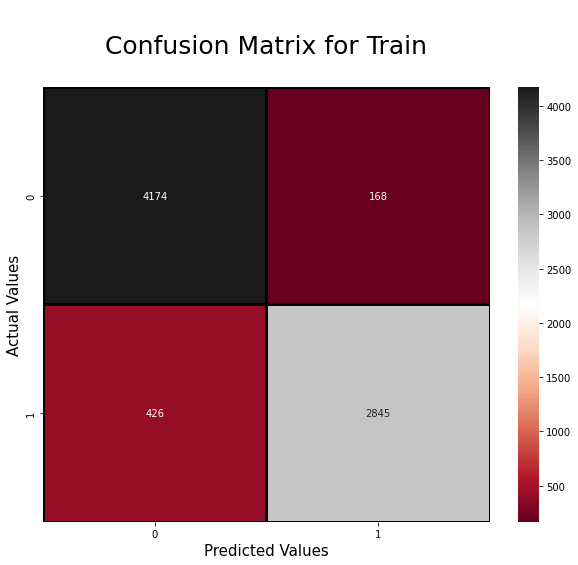

In [75]:
conf_matrix_plot(y_train, pred_train_stack)

As can be seen in the **Confusion Matrix**, the **model is better at identifying a fake tweet than a real tweet.**

This could be seen from print_metric(). **Precision is noticeably higher than Recall**

However, **using predict_proba()**, we could get the probabilities of the classes of the target feature and by changing the treshold of probabilities to **balance these class**

Let me demonstrate it

In [76]:
pred_train_stack_proba = stacking.predict_proba(X_train_tfid)[:,1]

In [77]:
treshold = 0.36

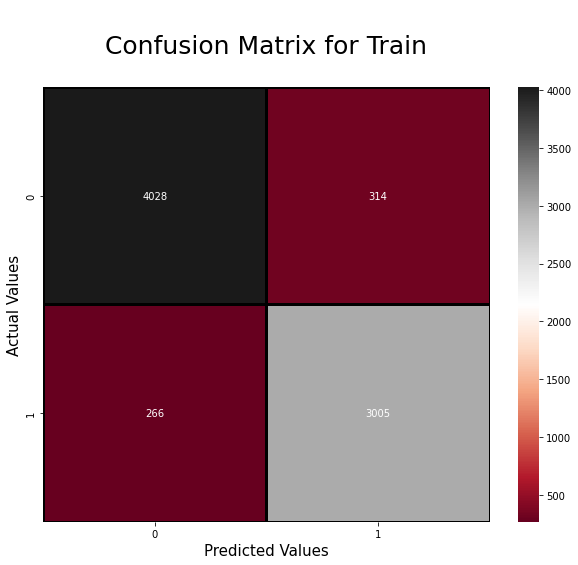

In [78]:
conf_matrix_plot(y_train, np.where(pred_train_stack_proba > treshold , 1, 0))

--------------------------

As you can see, the **mispredicted classes have become more balanced.**

Great, let's make a final prediction and put it on **Kaggle**

In [79]:
final_predict = stacking.predict_proba(X_test_tfid)[:,1]

In [80]:
final_predict = np.where(final_predict>0.5, 1, 0)

In [81]:
submission = pd.DataFrame({'Id':test.id, 'target': final_predict})

In [82]:
submission.T

,0,1,2,3,4,5,6,7,8,9,...,3253,3254,3255,3256,3257,3258,3259,3260,3261,3262
Id,0,2,3,9,11,12,21,22,27,29,...,10838,10845,10856,10857,10858,10861,10865,10868,10874,10875
target,1,1,1,1,1,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [83]:
#submission.to_csv('submission_NLP.csv', index=False)

## <center>Thank you for watching my project, I will be grateful if you upvoted and give feedback about my work in the comments. I want to improve my skills, and if you find any mistakes in the project, please tell me about it. Also, if you liked the structure of the project, you can see the rest of my project, in each of them I try to describe my actions in detail, as well as not just solve the problem, but use new technologies </center>

![](https://data.whicdn.com/images/218833361/original.gif)